# Homework 5: PCA / LDA 主成分降維

C111156103, 潘奕濬

## 環境設定

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from ucimlrepo import fetch_ucirepo
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [2]:
import matplotlib_inline

matplotlib_inline.backend_inline.set_matplotlib_formats("svg")

## Import data from UCI machine learning repository

In [3]:
# fetch dataset
mushroom = fetch_ucirepo(id=73)

# data (as pandas dataframes)
assert mushroom.data is not None
assert isinstance(mushroom.data.features, pd.DataFrame)
assert isinstance(mushroom.data.targets, pd.DataFrame)

X = mushroom.data.features
y = mushroom.data.targets

## 缺失值處理 - missing values

In [4]:
# Check missing values
missing_values = X.isnull().sum()
print("特徵缺失值：")
print(missing_values)

missing_values_y = y.isnull().sum()
print("\n目標變數缺失值：")
print(missing_values_y)

特徵缺失值：
cap-shape                      0
cap-surface                    0
cap-color                      0
bruises                        0
odor                           0
gill-attachment                0
gill-spacing                   0
gill-size                      0
gill-color                     0
stalk-shape                    0
stalk-root                  2480
stalk-surface-above-ring       0
stalk-surface-below-ring       0
stalk-color-above-ring         0
stalk-color-below-ring         0
veil-type                      0
veil-color                     0
ring-number                    0
ring-type                      0
spore-print-color              0
population                     0
habitat                        0
dtype: int64

目標變數缺失值：
poisonous    0
dtype: int64


很明顯 stalk-root 有一個缺失值。查看缺失值相對於所有值的比例。

In [5]:
missing_ratio = X.isnull().sum().sum() / X.shape[0]
print(f"缺失值比例：{missing_ratio:.2%}")

缺失值比例：30.53%


居然有 30%！要不就刪除這一個 column 好了 …

In [6]:
# drop 'stalk-root' column and meaningless column
Xc = X.drop(columns=["stalk-root", "veil-type"])

## Label 分類數值

### 各特徵的唯一值數量及其項目

In [7]:
# 各特徵的唯一值數量及其項目
for _col in Xc.columns:
    print(f"\n{_col}: {Xc[_col].nunique()} 個唯一值")
    print(Xc[_col].value_counts())

# 建立一個包含每個特徵的唯一值數量和項目的DataFrame
features_info = []
for _col in Xc.columns:
    _unique_values = Xc[_col].unique().tolist()
    features_info.append(
        {"feature": _col, "unique_count": Xc[_col].nunique(), "values": _unique_values}
    )

features_info_df = pd.DataFrame(features_info)
features_info_df


cap-shape: 6 個唯一值
cap-shape
x    3656
f    3152
k     828
b     452
s      32
c       4
Name: count, dtype: int64

cap-surface: 4 個唯一值
cap-surface
y    3244
s    2556
f    2320
g       4
Name: count, dtype: int64

cap-color: 10 個唯一值
cap-color
n    2284
g    1840
e    1500
y    1072
w    1040
b     168
p     144
c      44
u      16
r      16
Name: count, dtype: int64

bruises: 2 個唯一值
bruises
f    4748
t    3376
Name: count, dtype: int64

odor: 9 個唯一值
odor
n    3528
f    2160
y     576
s     576
a     400
l     400
p     256
c     192
m      36
Name: count, dtype: int64

gill-attachment: 2 個唯一值
gill-attachment
f    7914
a     210
Name: count, dtype: int64

gill-spacing: 2 個唯一值
gill-spacing
c    6812
w    1312
Name: count, dtype: int64

gill-size: 2 個唯一值
gill-size
b    5612
n    2512
Name: count, dtype: int64

gill-color: 12 個唯一值
gill-color
b    1728
p    1492
w    1202
n    1048
g     752
h     732
u     492
k     408
e      96
y      86
o      64
r      24
Name: count, dtype: int64

st

feature  unique_count  \
0                  cap-shape             6   
1                cap-surface             4   
2                  cap-color            10   
3                    bruises             2   
4                       odor             9   
5            gill-attachment             2   
6               gill-spacing             2   
7                  gill-size             2   
8                 gill-color            12   
9                stalk-shape             2   
10  stalk-surface-above-ring             4   
11  stalk-surface-below-ring             4   
12    stalk-color-above-ring             9   
13    stalk-color-below-ring             9   
14                veil-color             4   
15               ring-number             3   
16                 ring-type             5   
17         spore-print-color             9   
18                population             6   
19                   habitat             7   

                                  values  
0                     [x, b, s, f, k, c]  
1                           [s, y, f, g]  
2         [n, y, w, g, e, p, b, u, c, r]  
3                                 [t, f]  
4            [p, a, l, n, f, c, y, s, m]  
5                                 [f, a]  
6                                 [c, w]  
7                                 [n, b]  
8   [k, n, g, p, w, h, u, e, b, r, y, o]  
9                                 [e, t]  
10                          [s, f, k, y]  
11                          [s, f, y, k]  
12           [w, g, p, n, b, e, o, c, y]  
13           [w, p, g, b, n, e, y, o, c]  
14                          [w, n, o, y]  
15                             [o, t, n]  
16                       [p, e, l, f, n]  
17           [k, n, u, h, w, r, o, y, b]  
18                    [s, n, a, v, y, c]  
19                 [u, g, m, d, p, w, l]

### 針對 Binary 資料使用 label encoder

In [8]:
Xc_encoded_part1 = Xc.copy()

binary_features = features_info_df[features_info_df["unique_count"] <= 2]

le = LabelEncoder()
for col in binary_features["feature"]:
    Xc_encoded_part1[col] = le.fit_transform(Xc_encoded_part1[col])

### 針對 Non-binary 資料使用 one-hot encoder

In [9]:
onehot_features = features_info_df[features_info_df["unique_count"] > 2]

Xc_encoded = pd.get_dummies(
    Xc_encoded_part1, columns=list(onehot_features["feature"]), dtype="int64"
)
Xc_encoded

bruises  gill-attachment  gill-spacing  gill-size  stalk-shape  \
0           1                1             0          1            0   
1           1                1             0          0            0   
2           1                1             0          0            0   
3           1                1             0          1            0   
4           0                1             1          0            1   
...       ...              ...           ...        ...          ...   
8119        0                0             0          0            0   
8120        0                0             0          0            0   
8121        0                0             0          0            0   
8122        0                1             0          1            1   
8123        0                0             0          0            0   

      cap-shape_b  cap-shape_c  cap-shape_f  cap-shape_k  cap-shape_s  ...  \
0               0            0            0            0            0  ...   
1               0            0            0            0            0  ...   
2               1            0            0            0            0  ...   
3               0            0            0            0            0  ...   
4               0            0            0            0            0  ...   
...           ...          ...          ...          ...          ...  ...   
8119            0            0            0            1            0  ...   
8120            0            0            0            0            0  ...   
8121            0            0            1            0            0  ...   
8122            0            0            0            1            0  ...   
8123            0            0            0            0            0  ...   

      population_s  population_v  population_y  habitat_d  habitat_g  \
0                1             0             0          0          0   
1                0             0             0          0          1   
2                0             0             0          0          0   
3                1             0             0          0          0   
4                0             0             0          0          1   
...            ...           ...           ...        ...        ...   
8119             0             0             0          0          0   
8120             0             1             0          0          0   
8121             0             0             0          0          0   
8122             0             1             0          0          0   
8123             0             0             0          0          0   

      habitat_l  habitat_m  habitat_p  habitat_u  habitat_w  
0             0          0          0          1          0  
1             0          0          0          0          0  
2             0          1          0          0          0  
3             0          0          0          1          0  
4             0          0          0          0          0  
...         ...        ...        ...        ...        ...  
8119          1          0          0          0          0  
8120          1          0          0          0          0  
8121          1          0          0          0          0  
8122          1          0          0          0          0  
8123          1          0          0          0          0  

[8124 rows x 106 columns]

## 針對目標變數進行 label encoding

In [10]:
# encode y to int
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y.to_numpy().ravel())

y_encoded

array([1, 0, 0, ..., 0, 1, 0], shape=(8124,))

## 切割資料集與訓練集

In [11]:
X_train, X_test, y_train, y_test = train_test_split(
    Xc_encoded, y_encoded, test_size=0.2, random_state=42, stratify=y
)

## 各種降維方法

### PCA 降維

#### 各個主成分解釋變異數

In [12]:
from sklearn.decomposition import PCA

pca = PCA()
pca.fit(X_train)
pca.explained_variance_ratio_

array([1.67578180e-01, 1.22475132e-01, 8.96308214e-02, 5.40603477e-02,
       4.26479495e-02, 3.73399977e-02, 3.42785033e-02, 2.88506874e-02,
       2.48117964e-02, 2.37771959e-02, 2.24025141e-02, 2.06831007e-02,
       1.97271215e-02, 1.79898760e-02, 1.73600180e-02, 1.67740048e-02,
       1.63209660e-02, 1.59189562e-02, 1.37513025e-02, 1.27891033e-02,
       1.18731952e-02, 1.10669280e-02, 1.08312897e-02, 1.01437389e-02,
       9.51917637e-03, 8.88184566e-03, 8.64335166e-03, 8.38789143e-03,
       8.02611249e-03, 7.54451779e-03, 7.07318201e-03, 6.64878786e-03,
       6.26536933e-03, 5.89538562e-03, 5.66514989e-03, 5.50522812e-03,
       5.23180895e-03, 4.97350569e-03, 4.87851900e-03, 4.44584133e-03,
       4.33241437e-03, 3.81218756e-03, 3.70054115e-03, 3.35855272e-03,
       3.19763736e-03, 3.03000282e-03, 2.63897450e-03, 2.40185762e-03,
       2.20127152e-03, 2.17459853e-03, 1.99219727e-03, 1.70970157e-03,
       1.47216654e-03, 1.34996900e-03, 1.16745663e-03, 1.11897640e-03,
      

#### 各個主成分累積變異數（圖）

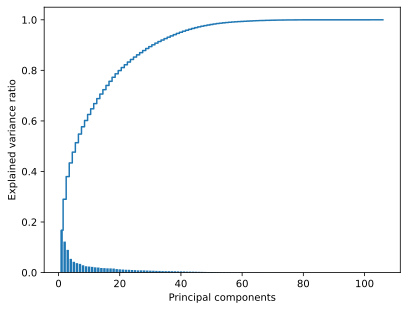

In [13]:
import numpy as np

plt.bar(
    range(1, len(pca.explained_variance_ratio_) + 1),
    pca.explained_variance_ratio_,
    align="center",
)
plt.step(
    range(1, len(pca.explained_variance_ratio_) + 1),
    np.cumsum(pca.explained_variance_ratio_),
    where="mid",
)
plt.ylabel("Explained variance ratio")
plt.xlabel("Principal components")

plt.show()

#### 決定要取幾個主成分

這裡選取 2 個特徵。

In [14]:
n_components = 2

pca = PCA(n_components=n_components)
pca.set_output(transform="pandas")
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

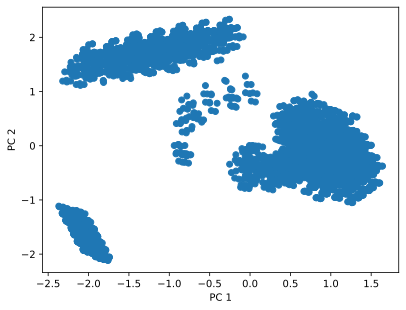

In [15]:
assert isinstance(X_train_pca, pd.DataFrame), "X_train_pca must be a pandas DataFrame"
assert isinstance(X_test_pca, pd.DataFrame), "X_test_pca must be a pandas DataFrame"

plt.scatter(X_train_pca.to_numpy()[:, 0], X_train_pca.to_numpy()[:, 1])
plt.xlabel("PC 1")
plt.ylabel("PC 2")
plt.show()

### LDA 降維

In [16]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

lda = LinearDiscriminantAnalysis()
lda.set_output(transform="pandas")
X_train_lda = lda.fit_transform(X_train, y_train)
X_test_lda = lda.transform(X_test)
lda.explained_variance_ratio_

array([1.])

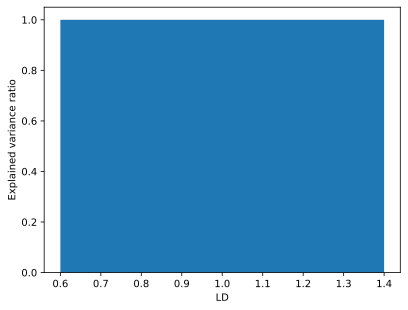

In [17]:
import numpy as np

plt.bar(
    range(1, len(lda.explained_variance_ratio_) + 1),
    lda.explained_variance_ratio_,
    align="center",
)
plt.step(
    range(1, len(lda.explained_variance_ratio_) + 1),
    np.cumsum(lda.explained_variance_ratio_),
    where="mid",
)
plt.ylabel("Explained variance ratio")
plt.xlabel("LD")

plt.show()

### PLS 降維（最初做法）

In [18]:
from sklearn.cross_decomposition import PLSRegression

plsr = PLSRegression(n_components=2)
plsr.set_output(transform="pandas")
X_train_pls, _ = plsr.fit_transform(X_train, y_train)
X_test_pls = plsr.transform(X_test)

### 使用隨機森林找出重要的特徵

In [19]:
import numpy as np
from sklearn.ensemble import RandomForestClassifier

feat_labels = X_train.columns
forest = RandomForestClassifier(random_state=42)

forest.fit(X_train, y_train)

importances = forest.feature_importances_
indices = np.argsort(importances)[::-1]
top_indices = indices[:2]

X_train_fs = X_train[feat_labels[top_indices]]
X_test_fs = X_test[feat_labels[top_indices]]

## 輸出 Accuracy 和決策圖

In [20]:
from typing import Callable
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

methods: list[tuple[str, Callable[[], LogisticRegression | SVC]]] = [
    (
        "Logistic Regression",
        lambda: LogisticRegression(max_iter=1000, random_state=42, n_jobs=8),
    ),
    ("SVM", lambda: SVC(kernel="rbf", random_state=42, gamma="auto", C=10.0)),
]

assert isinstance(X_train_pca, pd.DataFrame), "X_train_pca must be a pandas DataFrame"
assert isinstance(X_test_pca, pd.DataFrame), "X_test_pca must be a pandas DataFrame"
assert isinstance(X_train_lda, pd.DataFrame), "X_train_lda must be a pandas DataFrame"
assert isinstance(X_test_lda, pd.DataFrame), "X_test_lda must be a pandas DataFrame"
assert isinstance(y_train, np.ndarray), "y_train must be a numpy array"
assert isinstance(y_test, np.ndarray), "y_test must be a numpy array"

# (method_name, X_train, X_test, y_train, y_test)
x_y_sets: list[tuple[str, pd.DataFrame, pd.DataFrame, np.ndarray, np.ndarray]] = [
    ("PCA", X_train_pca, X_test_pca, y_train, y_test),
    ("LDA", X_train_lda, X_test_lda, y_train, y_test),
]

In [21]:
import warnings
from mlxtend.plotting import plot_decision_regions

plt.figure(figsize=(20, 15))

# 2x2 的圖表
_, ax = plt.subplots(2, 2)

for i, (method_name, construct_method) in enumerate(methods):
    for j, (feature_method_name, X_train, X_test, y_train, y_test) in enumerate(
        x_y_sets
    ):
        method = construct_method()

        method.fit(X_train, y_train)
        y_pred = method.predict(X_test)
        print(
            f"{method_name} Accuracy ({feature_method_name}): {accuracy_score(y_test, y_pred)}"
        )

        # 繪製決策圖 (suppresses warning)
        with warnings.catch_warnings():
            warnings.filterwarnings("ignore", category=UserWarning)
            plot_decision_regions(X_train.to_numpy(), y_train, clf=method, ax=ax[i][j])

        ax[i][j].set_title(f"{feature_method_name} on {method_name}")

plt.tight_layout()
plt.show()

Logistic Regression Accuracy (PCA): 0.8824615384615384
Logistic Regression Accuracy (LDA): 0.9987692307692307
SVM Accuracy (PCA): 0.8996923076923077
SVM Accuracy (LDA): 0.9987692307692307


<Figure size 2000x1500 with 0 Axes>

## Accuracy 比較表

In [22]:
from typing import Callable
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

methods: list[tuple[str, Callable[[], LogisticRegression | SVC]]] = [
    (
        "Logistic Regression",
        lambda: LogisticRegression(max_iter=1000, random_state=42, n_jobs=8),
    ),
    ("SVM", lambda: SVC(kernel="rbf", random_state=42, gamma="auto", C=10.0)),
]

assert isinstance(X_train_pca, pd.DataFrame), "X_train_pca must be a pandas DataFrame"
assert isinstance(X_test_pca, pd.DataFrame), "X_test_pca must be a pandas DataFrame"
assert isinstance(X_train_lda, pd.DataFrame), "X_train_lda must be a pandas DataFrame"
assert isinstance(X_test_lda, pd.DataFrame), "X_test_lda must be a pandas DataFrame"
assert isinstance(X_train_pls, pd.DataFrame), "X_train_pls must be a pandas DataFrame"
assert isinstance(X_test_pls, pd.DataFrame), "X_test_pls must be a pandas DataFrame"
assert isinstance(X_train_fs, pd.DataFrame), "X_train_fs must be a pandas DataFrame"
assert isinstance(X_test_fs, pd.DataFrame), "X_test_fs must be a pandas DataFrame"
assert isinstance(y_train, np.ndarray), "y_train must be a numpy array"
assert isinstance(y_test, np.ndarray), "y_test must be a numpy array"

# (method_name, X_train, X_test, y_train, y_test)
x_y_sets: list[tuple[str, pd.DataFrame, pd.DataFrame, np.ndarray, np.ndarray]] = [
    ("PCA", X_train_pca, X_test_pca, y_train, y_test),
    ("LDA", X_train_lda, X_test_lda, y_train, y_test),
    ("PLS (Original)", X_train_pls, X_test_pls, y_train, y_test),
    ("Feature Selection", X_train_fs, X_test_fs, y_train, y_test),
]

In [23]:
# Create a table to store accuracy scores
accuracy_table = []

for x_y_set_name, X_train, X_test, y_train, y_test in x_y_sets:
    row = [x_y_set_name]
    for method_name, construct_method in methods:
        method = construct_method()
        method.fit(X_train, y_train)
        y_pred = method.predict(X_test)
        acc = accuracy_score(y_test, y_pred)
        row.append(f"{acc:.4f}")
    accuracy_table.append(row)

# Convert to pandas DataFrame
df = pd.DataFrame(accuracy_table, columns=["Method"] + [m[0] for m in methods])
df = df.set_index("Method")

df

Logistic Regression     SVM
Method                                       
PCA                            0.8825  0.8997
LDA                            0.9988  0.9988
PLS (Original)                 0.9975  0.9988
Feature Selection              0.8855  0.8855